<a href="https://colab.research.google.com/github/Deepraj202219/Ai-Task-Management-System-v1/blob/main/AI_TASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import time

all_issues = []
start_at = 0
max_results = 100  # Jira API max per request

while True:
    url = "https://issues.apache.org/jira/rest/api/2/search"
    params = {
        "jql": "project=HADOOP",
        "fields": "summary,description,priority,status,created,assignee",
        "startAt": start_at,
        "maxResults": max_results
    }

    response = requests.get(url, params=params)
    data = response.json()

    issues = data.get("issues", [])
    if not issues:
        break  # no more issues to fetch

    for issue in issues:
        f = issue["fields"]
        all_issues.append({
            "summary": f.get("summary", ""),
            "description": f.get("description", ""),
            "priority": f.get("priority", {}).get("name", ""),
            "status": f.get("status", {}).get("name", ""),
            "created": f.get("created", ""),
            "assignee": f.get("assignee").get("displayName", "") if f.get("assignee") else ""
        })

    start_at += max_results
    time.sleep(0.5)  # be polite to API server

print(f"✅ Fetched {len(all_issues)} total issues")

# Create DataFrame with all issues
df = pd.DataFrame(all_issues)


✅ Fetched 17263 total issues


In [ ]:
# View first few rows
print(df.head())

# Check data types and missing values
print(df.info())

# Check summary statistics (for datetime or numeric fields)
print(df.describe(include='all'))

# Count missing values
print(df.isnull().sum())


                                             summary  \
0  Update the command usage of NNThroughputBenchm...   
1  Upgrade com.huaweicloud:esdk-obs-java for CVE-...   
2  Improve error message when the path contains d...   
3  Insert Overwrite Jobs With MagicCommitter Fail...   
4  ABFS: [FNSOverBlob] Add Distinct String In Use...   

                                         description priority status  \
0  In HDFS-15652, make block size from NNThroughp...    Major   Open   
1  The {{com.huaweicloud:esdk-obs-java}} dependen...    Major   Open   
2  Currently, we display the following error mess...    Minor   Open   
3  Query engines which uses Magic Committer to ov...    Major   Open   
4  Add a unique identifier in FNS-Blob user agent...    Major   Open   

                        created      assignee  
0  2025-05-26T07:50:02.000+0000                
1  2025-05-25T08:19:54.000+0000                
2  2025-05-23T05:58:18.000+0000                
3  2025-05-22T10:18:50.000+0000       

In [ ]:
# 1. Convert 'created' column to datetime
df['created'] = pd.to_datetime(df['created'], errors='coerce')

# 2. Remove rows where critical columns are missing or empty
df = df.dropna(subset=['summary', 'priority', 'status'])
df = df[df['summary'].str.strip() != '']
df = df[df['priority'].str.strip() != '']
df = df[df['status'].str.strip() != '']

# Also drop rows with missing or empty descriptions
df = df.dropna(subset=['description'])
df = df[df['description'].str.strip() != '']

# 3. Remove duplicates based on 'summary' and 'description'
df = df.drop_duplicates(subset=['summary', 'description'])

# 4. Strip whitespace from string columns
str_cols = ['summary', 'description', 'priority', 'status', 'assignee']
for col in str_cols:
    df[col] = df[col].astype(str).str.strip()

# 5. Handle assignee column if always empty
if df['assignee'].nunique() == 1 and df['assignee'].iloc[0] == '':
    df['assignee'] = df['assignee'].replace('', 'Unassigned')

# 6. Drop any rows with remaining NaNs and reset index
df = df.dropna().reset_index(drop=True)

print(df.info())
print(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4723 entries, 0 to 4722
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   summary      4723 non-null   object             
 1   description  4723 non-null   object             
 2   priority     4723 non-null   object             
 3   status       4723 non-null   object             
 4   created      4723 non-null   datetime64[ns, UTC]
 5   assignee     4723 non-null   object             
dtypes: datetime64[ns, UTC](1), object(5)
memory usage: 221.5+ KB
None
                            summary  \
count                          4723   
unique                         4708   
top     Updating incompatible issue   
freq                              3   
mean                            NaN   
min                             NaN   
25%                             NaN   
50%                             NaN   
75%                             NaN   
m

In [ ]:
!pip install nltk tqdm

import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm

# Download NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Combine summary and description for preprocessing
df['text'] = df['summary'].fillna('') + " " + df['description'].fillna('')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tqdm.pandas()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return " ".join(tokens)

df['clean_text'] = df['text'].progress_apply(preprocess_text)
df['clean_summary'] = df['summary'].progress_apply(preprocess_text)
df['clean_description'] = df['description'].progress_apply(preprocess_text)

print(df[['text', 'clean_text']].head())
print(df[['summary', 'clean_summary']].head())
print(df[['description', 'clean_description']].head())


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 4723/4723 [00:04<00:00, 1064.26it/s]

                                                text  \
0  Update the command usage of NNThroughputBenchm...   
1  Upgrade com.huaweicloud:esdk-obs-java for CVE-...   
2  Improve error message when the path contains d...   
3  Insert Overwrite Jobs With MagicCommitter Fail...   
4  ABFS: [FNSOverBlob] Add Distinct String In Use...   

                                          clean_text  
0  update command usage nnthroughputbenchmark add...  
1  upgrade com huaweicloud esdk ob java cve com h...  
2  improve error message path contains double sla...  
3  insert overwrite job magiccommitter fails expr...  
4  abfs fnsoverblob add distinct string user agen...  
                                             summary  \
0  Update the command usage of NNThroughputBenchm...   
1  Upgrade com.huaweicloud:esdk-obs-java for CVE-...   
2  Improve error message when the path contains d...   
3  Insert Overwrite Jobs With MagicCommitter Fail...   
4  ABFS: [FNSOverBlob] Add Distinct String In Use... 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Priority mapping (you already did this)
priority_map = {
    'Blocker': 'High',
    'Critical': 'High',
    'Major': 'Medium',
    'Minor': 'Low',
    'Trivial': 'Low'
}
df['priority_reduced'] = df['priority'].map(priority_map).fillna('Other')

# 2. Filter rows for relevant classes
df_model = df[df['priority_reduced'].isin(['High', 'Medium', 'Low'])].copy()

# 3. Prepare target
y = df_model['priority_reduced']

# 4. Prepare TF-IDF features on clean_text (re-create for df_model)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2), max_df=0.8, min_df=5, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(df_model['clean_text'])

# 5. Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Apply SMOTE to oversample minority classes in training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE class distribution:\n", y_train.value_counts())
print("After SMOTE class distribution:\n", y_train_res.value_counts())

# 7. Initialize logistic regression with class_weight='balanced' (optional, since SMOTE balances data)
clf = LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced', random_state=42)

# 8. Train model on oversampled data
clf.fit(X_train_res, y_train_res)

# 9. Predict on test set (original distribution)
y_pred = clf.predict(X_test)

# 10. Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Before SMOTE class distribution:
 priority_reduced
Medium    2495
Low        997
High       286
Name: count, dtype: int64
After SMOTE class distribution:
 priority_reduced
Medium    2495
Low       2495
High      2495
Name: count, dtype: int64
Accuracy: 0.5925925925925926

Classification Report:
               precision    recall  f1-score   support

        High       0.21      0.35      0.26        71
         Low       0.46      0.54      0.50       250
      Medium       0.75      0.64      0.69       624

    accuracy                           0.59       945
   macro avg       0.47      0.51      0.48       945
weighted avg       0.63      0.59      0.61       945


Confusion Matrix:
 [[ 25   8  38]
 [ 21 136  93]
 [ 73 152 399]]


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# 1. Filter dataset and target as before
priority_map = {
    'Blocker': 'High',
    'Critical': 'High',
    'Major': 'Medium',
    'Minor': 'Low',
    'Trivial': 'Low'
}
df['priority_reduced'] = df['priority'].map(priority_map).fillna('Other')
df_model = df[df['priority_reduced'].isin(['High', 'Medium', 'Low'])].copy()
y = df_model['priority_reduced']

# 2. Train-test split early on for reproducibility
X_train_df, X_test_df, y_train, y_test = train_test_split(
    df_model[['clean_text', 'assignee', 'status']],
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 3. Preprocessing pipelines for different columns
text_transformer = TfidfVectorizer(max_features=1000, ngram_range=(1,2), max_df=0.8, min_df=5, stop_words='english')

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# 4. ColumnTransformer to apply correct transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'clean_text'),
        ('cat', categorical_transformer, ['assignee', 'status'])
    ],
    sparse_threshold=0.3  # keeps sparse format if most features sparse
)

# 5. Build an imblearn Pipeline with SMOTE + Logistic Regression
pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# 6. Hyperparameter grid for tuning LogisticRegression
param_grid = {
    'clf__C': [0.001, 0.01, 0.1, 1, 10],          # Broader range for regularization strength
    'clf__solver': ['lbfgs', 'liblinear'],             # Common solvers
    'clf__penalty': ['l2'],                    # 'none' for no regularization (lbfgs only)
}

# 7. Grid search with 5-fold cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1, verbose=2)

# 8. Fit grid search
grid_search.fit(X_train_df, y_train)

# 9. Best params
print("Best parameters:", grid_search.best_params_)

# 10. Predict on test set
y_pred = grid_search.predict(X_test_df)

# 11. Evaluation
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Test Accuracy: 0.5873015873015873

Classification Report:
               precision    recall  f1-score   support

        High       0.16      0.30      0.21        71
         Low       0.48      0.60      0.53       250
      Medium       0.77      0.61      0.68       624

    accuracy                           0.59       945
   macro avg       0.47      0.50      0.47       945
weighted avg       0.65      0.59      0.61       945


Confusion Matrix:
 [[ 21  12  38]
 [ 22 151  77]
 [ 87 154 383]]


Fitting 2 folds for each of 8 candidates, totalling 16 fits

✅ Accuracy: 0.6339

📋 Classification Report:
               precision    recall  f1-score   support

        High       0.34      0.18      0.24        71
         Low       0.42      0.32      0.36       250
      Medium       0.71      0.81      0.76       624

    accuracy                           0.63       945
   macro avg       0.49      0.44      0.45       945
weighted avg       0.60      0.63      0.61       945



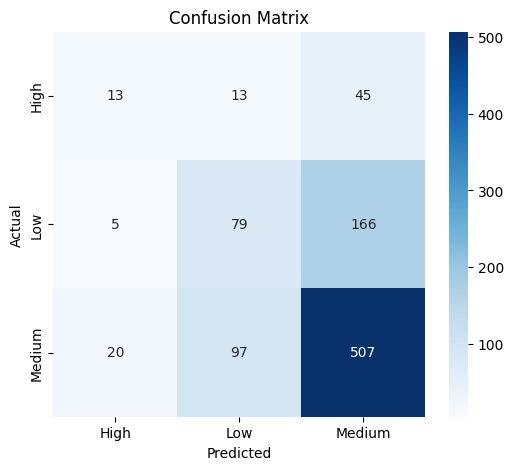

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from scipy.sparse import hstack
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Priority mapping
priority_map = {
    'Blocker': 'High',
    'Critical': 'High',
    'Major': 'Medium',
    'Minor': 'Low',
    'Trivial': 'Low'
}
df['priority_reduced'] = df['priority'].map(priority_map).fillna('Other')

# 2. Filter rows
df_model = df[df['priority_reduced'].isin(['High', 'Medium', 'Low'])].copy()
X_text = df_model['clean_text']
X_cat = df_model[['assignee', 'status']]
y = df_model['priority_reduced']

# 3. Train-test split
X_train_text, X_test_text, X_train_cat, X_test_cat, y_train, y_test = train_test_split(
    X_text, X_cat, y, test_size=0.2, random_state=42, stratify=y
)

# 4. TF-IDF for text
tfidf = TfidfVectorizer(max_features=5000)
X_train_text_tfidf = tfidf.fit_transform(X_train_text)
X_test_text_tfidf = tfidf.transform(X_test_text)

# 5. One-hot for categorical features
ohe = OneHotEncoder(handle_unknown='ignore')
X_train_cat_ohe = ohe.fit_transform(X_train_cat)
X_test_cat_ohe = ohe.transform(X_test_cat)

# 6. Combine features
X_train_final = hstack([X_train_text_tfidf, X_train_cat_ohe])
X_test_final = hstack([X_test_text_tfidf, X_test_cat_ohe])

# 7. Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 8. Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_final, y_train_enc)

# 9. Train-validation split for early stopping
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42, stratify=y_train_balanced
)

# 10. XGBoost with tuning
param_dist = {
    'max_depth': [3, 5, 6],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [75, 100],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
}

xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    verbosity=0,
    random_state=42
)

from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb_clf = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=-1,
    verbosity=0,
    random_state=42
)

param_dist = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0]
}

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=8,
    cv=2,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# ✅ Early stopping passed via fit_params dict (not unpacked!)
fit_params = {
    'eval_set': [(X_val_part, y_val_part)],
    'verbose': False
}

# ✅ This is how to use fit_params correctly
random_search.fit(X_train_part, y_train_part, **fit_params)

# 11. Final evaluation
best_model = random_search.best_estimator_
y_pred_enc = best_model.predict(X_test_final)
y_pred = le.inverse_transform(y_pred_enc)

print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

# 12. Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import joblib
import os

# Create model directory
os.makedirs("model", exist_ok=True)

# Save model and transformers
joblib.dump(best_model, 'model/final_xgb_classifier.joblib')
joblib.dump(tfidf, 'model/tfidf_vectorizer.joblib')
joblib.dump(ohe, 'model/onehot_encoder.joblib')
joblib.dump(le, 'model/label_encoder.joblib')

print("✅ Model and transformers saved in /model folder.")

# ✅ Load saved components
model = joblib.load('model/final_xgb_classifier.joblib')
tfidf = joblib.load('model/tfidf_vectorizer.joblib')
ohe = joblib.load('model/onehot_encoder.joblib')
le = joblib.load('model/label_encoder.joblib')

# Example new tasks to predict
new_tasks = pd.DataFrame({
    'clean_text': [
        "Fix bug in file upload module",
        "Improve logging for user sessions",
        "Handle edge case for password reset"
    ],
    'assignee': ['user1', 'user2', 'user1'],
    'status': ['Open', 'In Progress', 'Open']
})

# Preprocess text and categorical
X_text_new = tfidf.transform(new_tasks['clean_text'])
X_cat_new = ohe.transform(new_tasks[['assignee', 'status']])
X_new_final = hstack([X_text_new, X_cat_new])

# Predict
y_pred_new_enc = model.predict(X_new_final)
y_pred_new = le.inverse_transform(y_pred_new_enc)

# Output
for task, pred in zip(new_tasks['clean_text'], y_pred_new):
    print(f"📝 Task: {task}\n➡️ Predicted Priority: {pred}\n{'-'*60}")


✅ Model and transformers saved in /model folder.
📝 Task: Fix bug in file upload module
➡️ Predicted Priority: Medium
------------------------------------------------------------
📝 Task: Improve logging for user sessions
➡️ Predicted Priority: Medium
------------------------------------------------------------
📝 Task: Handle edge case for password reset
➡️ Predicted Priority: Medium
------------------------------------------------------------


In [ ]:
#app.py
!pip install streamlit
import streamlit as st
import pandas as pd
from scipy.sparse import hstack
import joblib

# Load saved components once
@st.cache_data
def load_model_components():
    model = joblib.load('model/final_xgb_classifier.joblib')
    tfidf = joblib.load('model/tfidf_vectorizer.joblib')
    ohe = joblib.load('model/onehot_encoder.joblib')
    le = joblib.load('model/label_encoder.joblib')
    return model, tfidf, ohe, le

model, tfidf, ohe, le = load_model_components()

st.title("📝 Task Priority Predictor")

# Input form for new task
with st.form("task_form"):
    task_text = st.text_area("Enter task description", height=100)
    assignee = st.text_input("Assignee username")
    status = st.selectbox("Status", options=["Open", "In Progress", "Closed"])
    submitted = st.form_submit_button("Predict Priority")

if submitted:
    # Prepare input dataframe
    new_task_df = pd.DataFrame({
        'clean_text': [task_text],
        'assignee': [assignee],
        'status': [status]
    })

    # Transform features
    X_text_new = tfidf.transform(new_task_df['clean_text'])
    X_cat_new = ohe.transform(new_task_df[['assignee', 'status']])
    X_new_final = hstack([X_text_new, X_cat_new])

    # Predict and decode
    y_pred_enc = model.predict(X_new_final)
    y_pred = le.inverse_transform(y_pred_enc)

    # Display prediction
    st.markdown(f"### Predicted Priority: **{y_pred[0]}**")


2025-05-27 17:43:10.957 No runtime found, using MemoryCacheStorageManager
2025-05-27 17:43:10.989 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 17:43:10.991 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 17:43:10.994 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 17:43:10.996 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 17:43:10.998 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 17:43:11.000 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 17:43:11.003 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-27 17:43:11.005 Thread 'MainThread':

In [ ]:
!ls /content/


model  sample_data


In [ ]:
# 1. Install nbconvert
!pip install --quiet nbconvert pyppeteer

# 2. Execute the notebook and convert to HTML
!jupyter nbconvert --to html --execute \
    --output executed_notebook.html "/content/AI TASK.ipynb"

# 3. Convert the same notebook to PDF
!jupyter nbconvert --to pdf \
    --output executed_notebook.pdf "/content/AI TASK.ipynb"



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 7.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.7.3 requires websockets>=14.0, but you have websockets 10.4 which is incompatible.
google-genai 1.15.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 10.4 which is incompatible.
yfinance 0.2.61 requires websockets>=13.0, but you have websockets 10.4 which is incompatible.
[NbConvertApp] WARNING | pattern '/content/AI TASK.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options be